In [186]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np




In [121]:
# Fetch Bitcoin historical data from Yahoo Finance
# btc_data = yf.download('BTC-USD', start='2022-01-01', end='2023-01-01')




# filename = 'btc_daily_data.csv'
# btc_data.to_csv(filename)

# filename = 'data/btcusdt_45m_db.csv'

# data = pd.read_csv(filename)  # Load your data

# # Comment out the following block if you want to run it on daily data. This was for my 45million dollar bars
# try:
#     # Create a "Date" column from 'open_time' column and convert it to datetime
#     data['Date'] = pd.to_datetime(data['open_time'], unit='s')
#     # data.index = pd.to_datetime(data['Date'])  # Set the index to be the Date
#     # data = data.drop('Date', axis=1)  # Drop the extra Date column
#     data['Close'] = data['close']  # Rename the Close to close
# except:
#     pass

Import 1 minute ETH data and get the dataframe ready for processing

In [190]:
eth_data = pd.read_csv('data/fixed_ETHUSDT.csv', index_col=0, parse_dates=True)
eth_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
resampled_data = eth_data.resample('30T').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
data = resampled_data
data.reset_index(inplace=True)
data.rename(columns={'datetime':'Date'}, inplace=True)
data


,Date,Open,High,Low,Close
0,2019-01-01 00:00:00+00:00,131.45,131.54,131.01,131.29
1,2019-01-01 00:30:00+00:00,131.28,132.22,131.16,131.82
2,2019-01-01 01:00:00+00:00,131.83,131.88,131.26,131.51
3,2019-01-01 01:30:00+00:00,131.50,131.53,131.00,131.14
4,2019-01-01 02:00:00+00:00,131.19,131.34,130.36,130.68
...,...,...,...,...,...
82399,2023-09-13 15:30:00+00:00,1610.21,1616.39,1607.13,1608.17
82400,2023-09-13 16:00:00+00:00,1608.17,1615.76,1606.06,1614.36
82401,2023-09-13 16:30:00+00:00,1614.37,1615.72,1609.16,1609.44
82402,2023-09-13 17:00:00+00:00,1609.44,1611.05,1600.65,1603.14


# Note 
`transition_state` is based on the *last* n states not the *current* state (this shouldn't be known until the close) so the current `pct_chg` is essentially the target variable that we are trying to predict based on the `transition_state` or the last several periods 

In [194]:
# Usage example:
n = 4  # Set the lookback window to 3 periods for 'n' binary digits in 'transition_state'

# Prep your dataframe
data['pct_chg'] = data['Close'].pct_change()  # Calculate percent change
data['binary'] = data['pct_chg'].apply(lambda x: 1 if x > 0 else 0)  # Calculate binary column for 'up' or 'down' days


def add_transition_state_optimized(df, lookback):
    # Calculate binary column for 'up' (1) or 'down' (0) days
    df['binary'] = (df['pct_chg'] > 0).astype(int)
    
    # Create shifted columns for the lookback period
    # Start with an empty DataFrame to collect the shifted states
    shifted_states = pd.DataFrame(index=df.index)
    for shift in range(1, lookback + 1):
        shifted_states[f'lag_{shift}'] = df['binary'].shift(shift)

    # Use dropna to remove rows with incomplete lookback data
    shifted_states.dropna(inplace=True)

    # Convert all lagged binary columns to integer for proper formatting and then to string
    for col in shifted_states.columns:
        shifted_states[col] = shifted_states[col].astype(int).astype(str)

    # Concatenate the binary state strings to form the transition state
    df['transition_state'] = shifted_states.apply(lambda x: ''.join(x), axis=1)

    # Ensure that only rows with a complete set of lookback data are returned
    return df[df['transition_state'].notna()]

# Add transition state column to the data efficiently
data_with_transition_state = add_transition_state_optimized(data, n)

# Print the DataFrame with the transition state
# print(data_with_transition_state[['Date', 'Close', 'pct_chg', 'binary', 'transition_state']].tail())

def analyze_transition_matrix(df, transition_column, return_column):
    # Make a copy of df to avoid SettingWithCopyWarning when df is a slice of another DataFrame
    df = df.copy()

    # Calculate the return multiplier for each row
    df['return_multiplier'] = 1 + df[return_column] / 100

    # Group by transition state and calculate statistics
    stats = df.groupby(transition_column).agg({
        return_column: ['mean', 'min', 'max', 'count'],
        'return_multiplier': 'prod'  # Calculate the compounded return
    })

    # Flatten the MultiIndex columns
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]

    # Calculate up/down counts and probabilities
    up_counts = df[df[return_column] > 0].groupby(transition_column)[return_column].count()
    down_counts = df[df[return_column] <= 0].groupby(transition_column)[return_column].count()
    total_counts = df.groupby(transition_column)[return_column].count()

    stats['prob_up'] = up_counts / total_counts
    stats['prob_down'] = down_counts / total_counts
    stats['cum_return'] = (stats['return_multiplier_prod'] - 1) * 100

    # Fill NaN values with zero where there were no up/down periods
    stats['prob_up'] = stats['prob_up'].fillna(0)
    stats['prob_down'] = stats['prob_down'].fillna(0)

    # Rename the columns for better readability
    stats.rename(columns={
        return_column + '_mean': 'avg_return', 
        return_column + '_min': 'min_return', 
        return_column + '_max': 'max_return',
        return_column + '_count': 'count'
    }, inplace=True)

    # Convert the mean, min, and max from decimal to percentage
    stats['avg_return'] *= 100
    stats['min_return'] *= 100
    stats['max_return'] *= 100

    # Print the transition analysis matrix
    # print("Transition Analysis Matrix:")
    # print(stats[['count', 'prob_down', 'prob_up', 'avg_return', 'min_return', 'max_return', 'cum_return']])
    return stats
# Usage example:
stats = analyze_transition_matrix(data_with_transition_state, 'transition_state', 'pct_chg')

stats[['count', 'prob_down', 'prob_up', 'avg_return', 'min_return', 'max_return', 'cum_return']]


,count,prob_down,prob_up,avg_return,min_return,max_return,cum_return
transition_state,,,,,,,
0000,3553,0.410076,0.589924,0.028342,-18.550067,5.281770,1.010701
0001,4819,0.434945,0.565055,0.020962,-7.054353,10.027347,1.013997
0010,5206,0.457933,0.542067,0.003343,-12.263851,15.786183,0.172726
0011,5217,0.466935,0.533065,0.009632,-7.479558,6.336021,0.502738
0100,5177,0.441182,0.558818,0.027741,-11.817674,7.033134,1.445056
0101,6193,0.471662,0.528338,0.010513,-9.687247,4.747690,0.651995
0110,5769,0.481713,0.518287,0.029551,-6.986478,8.016783,1.718274
0111,4977,0.489853,0.510147,0.028206,-5.163490,6.162217,1.412744
1000,4819,0.489521,0.510479,-0.017703,-6.542543,5.387424,-0.850558


# Example usage to run a simple backtest simulation
We can see above that there were 49 times that the market went down -> up -> up but then the showed a 65% probability of being down in the next period. let's short the market whenever this occurs.

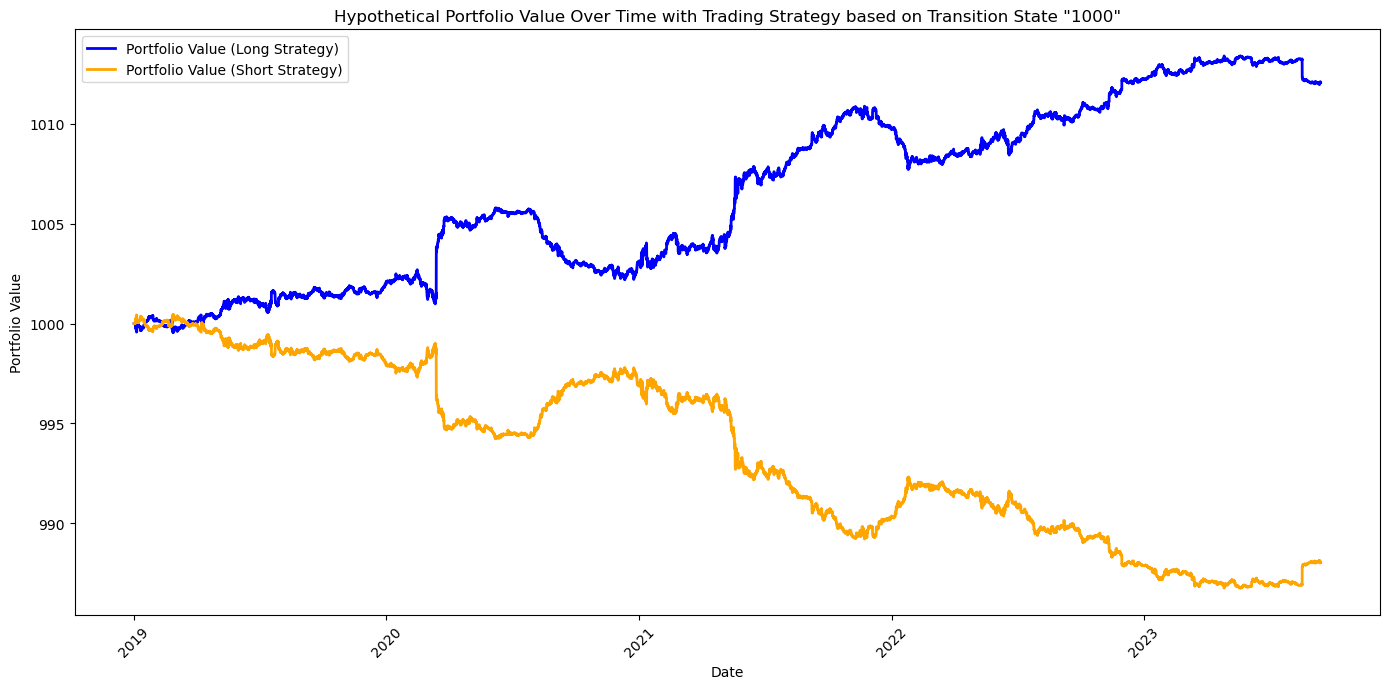

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Assuming data_with_transition_state is already defined and has the required 'transition_state' column
initial_capital = 1000  # Set the initial capital
test_state = '1000'  # Set the transition state to test
# Confirm that test state has n binary digits
assert len(test_state) == n, f'Test state "{test_state}" must have {n} binary digits'

# Make a copy of the dataframe to avoid SettingWithCopyWarning when df is a slice of another DataFrame
data_with_transition_state = data_with_transition_state.copy()

# Calculate return multipliers for both short and long strategies
data_with_transition_state['long_return_multiplier'] = 1 + data_with_transition_state['pct_chg'] / 100
data_with_transition_state['short_return_multiplier'] = 1 - data_with_transition_state['pct_chg'] / 100

# Create masks for the test state
investment_mask = data_with_transition_state['transition_state'] == test_state

# Initialize strategy multiplier columns to 1
data_with_transition_state['long_strategy_multiplier'] = 1
data_with_transition_state['short_strategy_multiplier'] = 1

# Apply strategy multipliers where the condition is True, based on the strategy
data_with_transition_state.loc[investment_mask, 'long_strategy_multiplier'] = data_with_transition_state.loc[investment_mask, 'long_return_multiplier']
data_with_transition_state.loc[investment_mask, 'short_strategy_multiplier'] = data_with_transition_state.loc[investment_mask, 'short_return_multiplier']

# Calculate cumulative portfolio values for both strategies
data_with_transition_state['long_cumulative_portfolio'] = initial_capital * data_with_transition_state['long_strategy_multiplier'].cumprod()
data_with_transition_state['short_cumulative_portfolio'] = initial_capital * data_with_transition_state['short_strategy_multiplier'].cumprod()

# Plot results for both strategies
plt.figure(figsize=(14, 7))
plt.plot(data_with_transition_state['Date'], data_with_transition_state['long_cumulative_portfolio'], marker='', color='blue', linewidth=2, label='Portfolio Value (Long Strategy)')
plt.plot(data_with_transition_state['Date'], data_with_transition_state['short_cumulative_portfolio'], marker='', color='orange', linewidth=2, label='Portfolio Value (Short Strategy)')
plt.title(f'Hypothetical Portfolio Value Over Time with Trading Strategy based on Transition State "{test_state}"')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
